In [0]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
# from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

<h1>Preparing the Data</h1>

This is what the data looks like:

In [0]:
data = pd.read_csv('data/Dataset_Weekly.csv')
# data = data.filter(regex=r'Drug|W')
data.head()

,Drug_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20,W21,W22,W23,W24,W25,W26,W27,W28,W29,W30,W31,W32,W33,W34,W35,W36,W37,W38,W39,W40,W41,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,D1,11,12,10,8,13,12,14,21,6,14,11,14,16,9,9,9,14,9,3,12,5,11,7,12,5,9,7,10,5,11,7,10,12,6,5,14,10,9,12,17,7,11,4,7,8,10,12,3,7,6,5,10
1,D2,7,6,3,2,7,1,6,3,3,3,2,2,6,2,0,6,2,7,7,9,4,7,2,4,5,3,5,8,5,5,3,1,3,2,3,10,5,2,7,3,2,5,2,4,5,1,1,4,5,1,6,0
2,D3,7,11,8,9,10,8,7,13,12,6,14,9,4,7,12,8,7,11,10,7,7,13,11,8,10,8,14,5,3,13,11,9,7,8,7,9,6,12,12,9,3,5,6,14,5,5,7,8,14,8,8,7
3,D4,12,8,13,5,9,6,9,13,13,11,8,4,5,4,15,7,11,9,15,4,6,7,11,7,9,6,10,10,2,6,7,2,5,12,5,19,8,6,8,8,12,6,9,10,3,4,6,8,14,8,7,8
4,D5,8,5,13,11,6,7,9,14,9,9,11,18,8,4,13,8,10,15,6,13,11,6,10,9,8,12,8,9,13,3,5,3,5,5,9,7,4,8,8,5,5,8,7,11,7,12,6,6,5,11,8,9


In [0]:
melt = data.melt(id_vars='Drug_Code', var_name='Week', value_name='Sales')

melt['Drug_Code'] = melt['Drug_Code'].str.extract('(\d+)', expand=False).astype(int)
melt['Week'] = melt['Week'].str.extract('(\d+)', expand=False).astype(int)

melt = melt.sort_values(['Week', 'Drug_Code'])
melt.head()

,Drug_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


# Basic Feature Engineering

We need to have variables to send to our model and get the predictions. For now, besides the product code and the week, I will create two features that usually help a lot with time series: lags and differences.

**Last Week Sales**: this is simply the amount of sales that a product had in the previous week  
**Last Week Diff**: the difference between the amount of sales in the previous week and the week before it (t-1 - t-2)

In [0]:
melt_copy = melt.copy()
melt_copy['Last_Week_Sales'] = melt_copy.groupby(['Drug_Code'])['Sales'].shift()
melt_copy['Last_Week_Diff'] = melt_copy.groupby(['Drug_Code'])['Last_Week_Sales'].diff()
melt_copy['Last-1_Week_Sales'] = melt_copy.groupby(['Drug_Code'])['Sales'].shift(2)
melt_copy['Last-1_Week_Diff'] = melt_copy.groupby(['Drug_Code'])['Last-1_Week_Sales'].diff()
melt_copy['Last-2_Week_Sales'] = melt_copy.groupby(['Drug_Code'])['Sales'].shift(3)
melt_copy['Last-2_Week_Diff'] = melt_copy.groupby(['Drug_Code'])['Last-2_Week_Sales'].diff()
melt_copy = melt_copy.dropna()
melt_copy.head()

,Drug_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff,Last-2_Week_Sales,Last-2_Week_Diff
3244,1,4,13,8.0,-2.0,10.0,-2.0,12.0,1.0
3245,2,4,7,2.0,-1.0,3.0,-3.0,6.0,-1.0
3246,3,4,10,9.0,1.0,8.0,-3.0,11.0,4.0
3247,4,4,9,5.0,-8.0,13.0,5.0,8.0,-4.0
3248,5,4,6,11.0,-2.0,13.0,8.0,5.0,-3.0


# Evaluating the Result

To know if our model is good we need to have an evaluation metric. A metric I really like for sales forecasting is the Root Mean Squared Log Error.

This is our well-known RMSE applied to the log of the target and the prediction output.

It works as an approximation to the percentage error between our predictions and the target, which is a nice way to understand the errors our model is making.

In [0]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

# Model

Gradient Boosted Trees.

There are many parameters we can tune for this model, but I will simply put 1000 trees with a small learning rate. If you want to improve the prediction, you can try tuning it.

In [0]:
mean_error = []
for week in range(46,52):
    train = melt_copy[melt_copy['Week'] < week]
    val = melt_copy[melt_copy['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    # print(p)
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

(811,)
Week 46 - Error 0.40386
(811,)
Week 47 - Error 0.38683
(811,)
Week 48 - Error 0.39838
(811,)
Week 49 - Error 0.40750
(811,)
Week 50 - Error 0.42086
(811,)
Week 51 - Error 0.45202
Mean Error = 0.41157


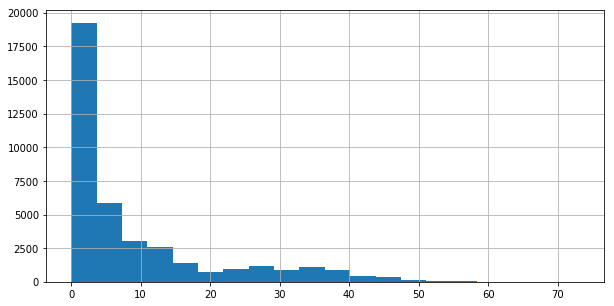

In [0]:
melt_copy['Sales'].hist(bins=20, figsize=(10,5))

# Improving the Solution

- Investigate products with sales over 25 units.
- Try more features (lags, differences) not only at the product level, but at the global.
- Try using LightGBM native support for categorical features with Product Code.
- Try tuning the model hyperparameters.
- Try a neural network and ensemble with GBM.